In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
df=pd.read_csv("D:/job requirements/projects/retail_sales/retail_store.csv")

In [5]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,01-01-2022,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,01-01-2022,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,01-01-2022,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,01-01-2022,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,01-01-2022,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [6]:
df['Date'].head()

0    01-01-2022
1    01-01-2022
2    01-01-2022
3    01-01-2022
4    01-01-2022
Name: Date, dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [8]:
df['Date'].head()

0   2022-01-01
1   2022-01-01
2   2022-01-01
3   2022-01-01
4   2022-01-01
Name: Date, dtype: datetime64[ns]

In [9]:
print(df.isnull().sum())

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64



Checking Trends & Seasonality

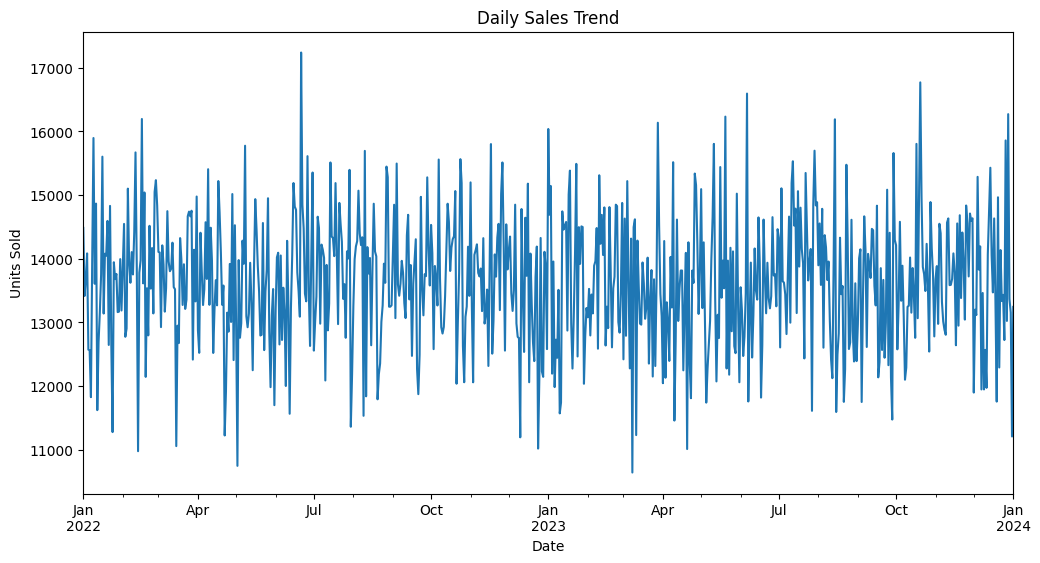

In [10]:
plt.figure(figsize=(12, 6))
df.groupby('Date')['Units Sold'].sum().plot()
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()



Analyzing Correlations

   Inventory Level  Units Sold  Units Ordered  Demand Forecast  Price  \
0              231         127             55           135.47  33.50   
1              204         150             66           144.04  63.01   
2              102          65             51            74.02  27.99   
3              469          61            164            62.18  32.72   
4              166          14            135             9.26  73.64   

   Discount  Holiday/Promotion  Competitor Pricing  
0        20                  0               29.69  
1        20                  0               66.16  
2        10                  1               31.32  
3        10                  1               34.74  
4         0                  0               68.95  


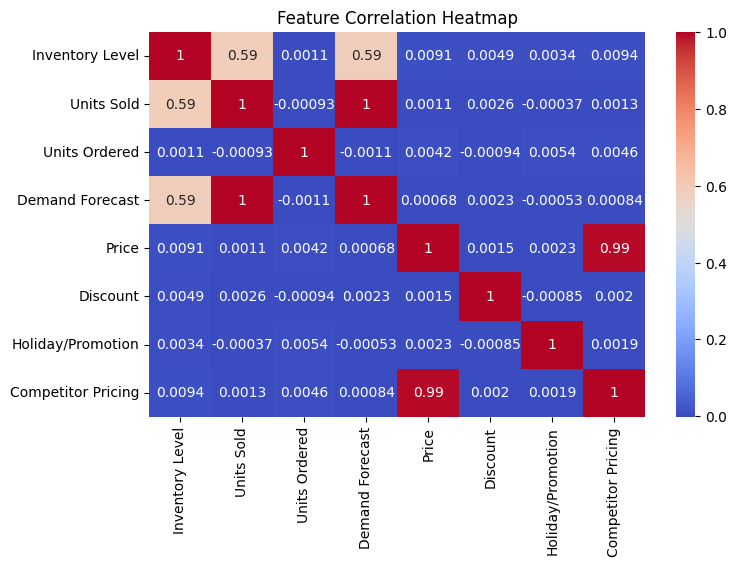

In [11]:
numeric_df = df.select_dtypes(include=['number']) 
print(numeric_df.head())  
numeric_df = numeric_df.fillna(0)
numeric_df = numeric_df.dropna()
plt.figure(figsize=(8, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


Creating Lag Features (Previous Sales as New Features)


In [12]:
df['Lag_1'] = df['Units Sold'].shift(1)  
df['Lag_7'] = df['Units Sold'].shift(7)  


adding Rolling Averages (Moving Average Features)

In [13]:
df['Rolling_7'] = df['Units Sold'].rolling(window=7).mean() 


Encoding Categorical Features

In [14]:
df = pd.get_dummies(df, columns=['Category', 'Region'], drop_first=True)


In [15]:
sales_data = df['Units Sold']

In [16]:
train_size = int(len(sales_data) * 0.8)
train, test = sales_data[:train_size], sales_data[train_size:]

In [17]:
model = ARIMA(train, order=(5,1,0))  
model_fit = model.fit()


In [18]:
forecast = model_fit.forecast(steps=len(test))

In [19]:
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 110.6261247390443


In [20]:
future_steps = 3
future_forecast = model_fit.forecast(steps=future_steps)
forecast_index = pd.date_range(start=sales_data.index[-1], periods=future_steps+1, freq='D')[1:]

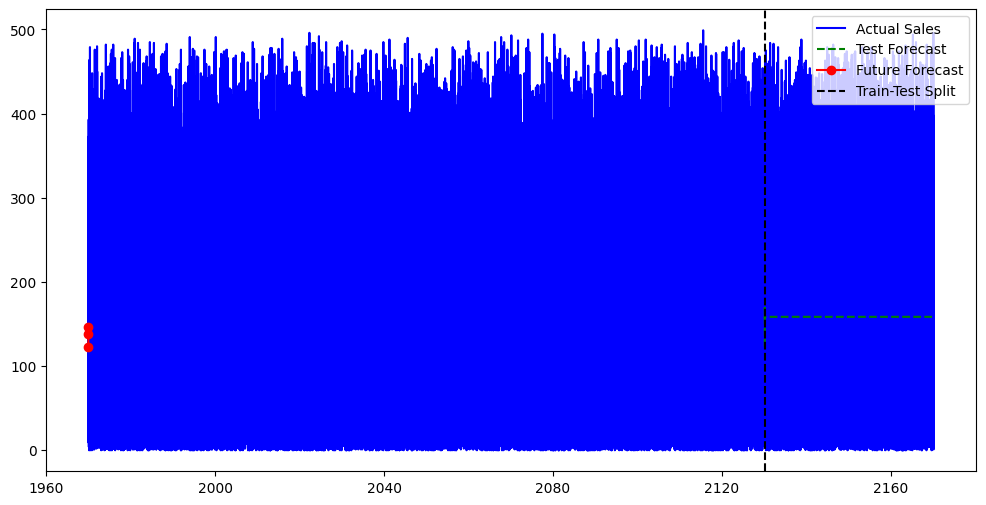

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data, label="Actual Sales", color='blue')
plt.plot(test.index, forecast, label="Test Forecast", color='green', linestyle="dashed")
plt.plot(forecast_index, future_forecast, label="Future Forecast", color='red', marker='o')
plt.axvline(x=test.index[0], color='black', linestyle="--", label="Train-Test Split")
plt.legend()
plt.show()

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pmdarima import auto_arima
best_model = auto_arima(train, 
                        seasonal=False,  
                        trace=True,  
                        suppress_warnings=True, 
                        stepwise=True)

print("Best ARIMA Order:", best_model.order)
model_fit = best_model.fit(train)
forecast = model_fit.predict(n_periods=len(test))
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=43.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=769906.026, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=742462.825, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=754880.746, Time=6.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=733705.273, Time=1.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=729307.044, Time=2.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=726365.151, Time=1.90 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=724490.710, Time=6.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=39.61 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=27.00 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=714744.169, Time=10.15 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=714742.731, Time=8.38 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=714740.845, Time=3.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=714745.437, Time=20.96 sec
 ARIMA(3,0,1)(0,0,0)[

20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing


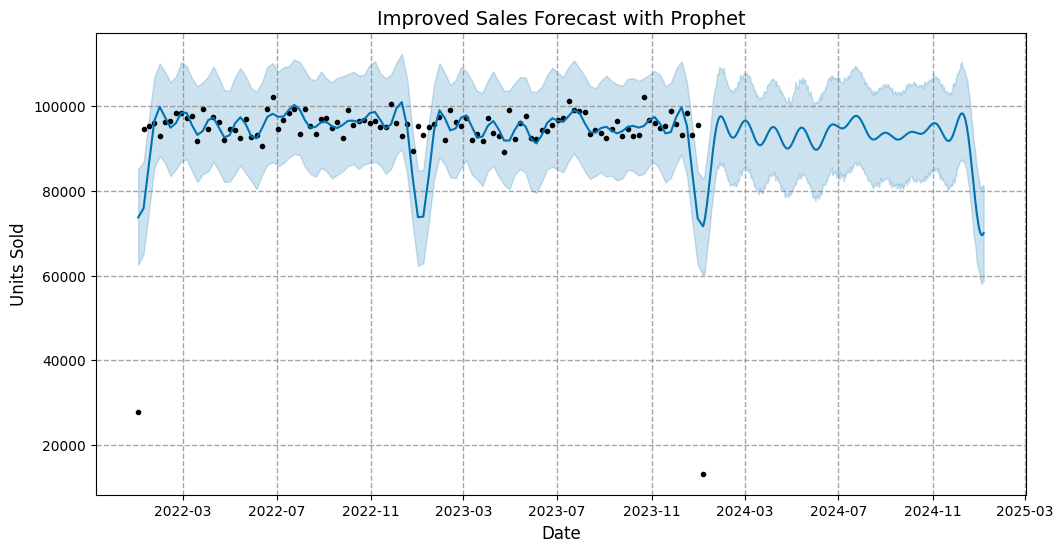

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

df['Date'] = pd.to_datetime(df['Date'])
df_resampled = df.resample('W', on='Date').sum()
prophet_df = df_resampled.reset_index()[['Date', 'Units Sold']].rename(columns={'Date': 'ds', 'Units Sold': 'y'})
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_df)
future_dates = prophet_model.make_future_dataframe(periods=365, freq='D')
forecast_prophet = prophet_model.predict(future_dates)
fig, ax = plt.subplots(figsize=(12, 6))
prophet_model.plot(forecast_prophet, ax=ax)

ax.set_title('Improved Sales Forecast with Prophet', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Units Sold', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [33]:
df['Lag_7'] = df['Units Sold'].shift(7)
df['Lag_14'] = df['Units Sold'].shift(14)
df['Lag_30'] = df['Units Sold'].shift(30)

In [34]:
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Is_Weekend'] = (df['Weekday'] >= 5).astype(int)

In [ ]:

holiday_list = ['2023-12-25', '2024-01-01', '2024-07-04']  
df['Is_Holiday'] = df['Date'].astype(str).isin(holiday_list).astype(int)

In [ ]:
import pandas as pd
import numpy as np


np.random.seed(42)

df['Date'] = pd.to_datetime(df['Date'])  
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
weather_df = pd.DataFrame({
    'Date': date_range,
    'Temperature': np.random.randint(15, 35, size=len(date_range))
})
promo_df = pd.DataFrame({
    'Date': date_range,
    'Discount': np.random.choice([0, 10, 20, 30], size=len(date_range)) 
})

economic_df = pd.DataFrame({
    'Date': date_range,
    'Inflation_Rate': np.random.uniform(2, 5, size=len(date_range))
})

df = df.merge(weather_df, on='Date', how='left')
df = df.merge(promo_df, on='Date', how='left')
df = df.merge(economic_df, on='Date', how='left')

df.rename(columns={'Date': 'ds'}, inplace=True)

print(df.head()) 


          ds Store ID Product ID  Inventory Level  Units Sold  Units Ordered  \
0 2022-01-01     S001      P0001              231         127             55   
1 2022-01-01     S001      P0002              204         150             66   
2 2022-01-01     S001      P0003              102          65             51   
3 2022-01-01     S001      P0004              469          61            164   
4 2022-01-01     S001      P0005              166          14            135   

   Demand Forecast  Price  Discount_x Weather Condition  ...  floor  Lag_14  \
0           135.47  33.50          20             Rainy  ...      0     NaN   
1           144.04  63.01          20             Sunny  ...      0     NaN   
2            74.02  27.99          10             Sunny  ...      0     NaN   
3            62.18  32.72          10            Cloudy  ...      0     NaN   
4             9.26  73.64           0             Sunny  ...      0     NaN   

  Lag_30  Month  Weekday  Is_Weekend  Is_Hol

In [42]:
df.dropna(inplace=True)


In [43]:
df.rename(columns={'Date': 'ds', 'Units Sold': 'y'}, inplace=True)


20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing


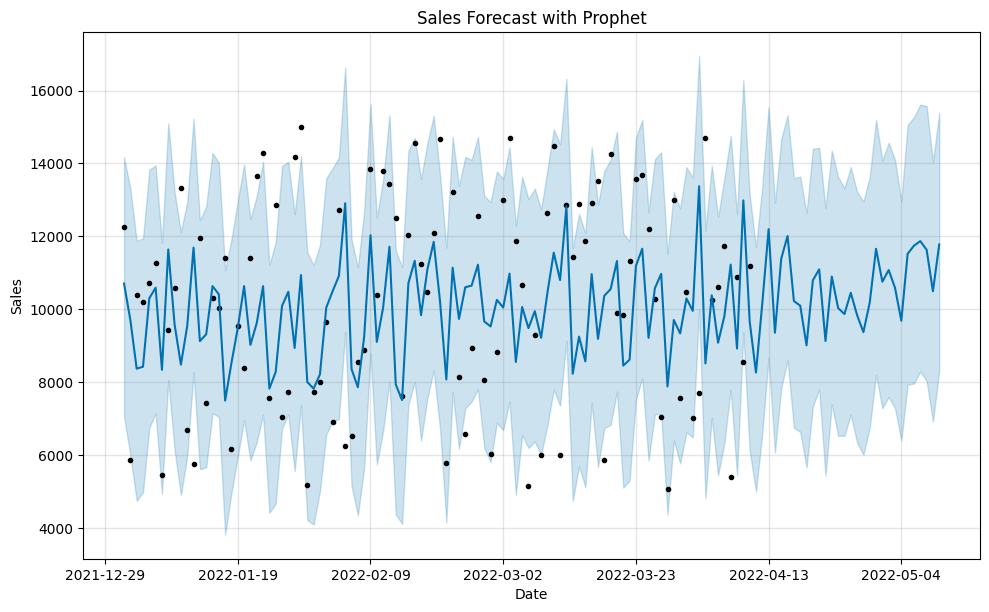

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
date_range = pd.date_range(start='2022-01-01', periods=100, freq='D')

df = pd.DataFrame({
    'ds': date_range,
    'y': np.random.randint(5000, 15000, size=len(date_range)) 
})

df['Temperature'] = np.random.randint(15, 35, size=len(df))
df['Discount'] = np.random.choice([0, 10, 20, 30], size=len(df))
df['Inflation_Rate'] = np.random.uniform(2, 5, size=len(df))

model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('Discount')
model.add_regressor('Inflation_Rate')

model.fit(df)
future = model.make_future_dataframe(periods=30)
future['Temperature'] = np.random.randint(15, 35, size=len(future))
future['Discount'] = np.random.choice([0, 10, 20, 30], size=len(future))
future['Inflation_Rate'] = np.random.uniform(2, 5, size=len(future))
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title("Sales Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [ ]:

from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
df_cv = cross_validation(model, initial='60 days', period='10 days', horizon='30 days')

df_perf = performance_metrics(df_cv, metrics=['mae', 'mape', 'rmse'])
print("📊 Prophet Model Performance:\n", df_perf)

actual = df_cv['y']
predicted = df_cv['yhat']
r2 = r2_score(actual, predicted)
print(f"🔢 Prophet R² Score: {r2:.2f}")
df['Moving_Avg'] = df['y'].rolling(window=7).mean() 

df_baseline = df.dropna(subset=['Moving_Avg'])


baseline_mae = mean_absolute_error(df_baseline['y'], df_baseline['Moving_Avg'])
baseline_mape = mean_absolute_percentage_error(df_baseline['y'], df_baseline['Moving_Avg'])
baseline_r2 = r2_score(df_baseline['y'], df_baseline['Moving_Avg'])


print("\n Baseline Model (Moving Average) Performance:")
print(f"MAE: {baseline_mae:.2f} | MAPE: {baseline_mape:.2%} | R² Score: {baseline_r2:.2f}")

print("\n Prophet vs Baseline Model Performance Comparison:")
print(f" Prophet  → MAE: {df_perf['mae'].mean():.2f}, MAPE: {df_perf['mape'].mean():.2%}, R²: {r2:.2f}")
print(f" Baseline → MAE: {baseline_mae:.2f}, MAPE: {baseline_mape:.2%}, R²: {baseline_r2:.2f}")


  0%|          | 0/1 [00:00<?, ?it/s]

20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


📊 Prophet Model Performance:
    horizon          mae      mape         rmse
0   3 days  1787.313588  0.140938  2145.519088
1   4 days  2559.638320  0.208776  2883.635570
2   5 days  2613.854513  0.210697  2897.970130
3   6 days  1809.684682  0.147076  2194.284125
4   7 days  2290.869307  0.330838  2989.507837
5   8 days  2371.440541  0.334417  3015.443763
6   9 days  2401.635969  0.346744  3026.109585
7  10 days   909.041575  0.080737   948.294990
8  11 days  1102.891439  0.104430  1197.315385
9  12 days  1281.008955  0.107375  1387.438610
10 13 days  2088.767886  0.161419  2175.896877
11 14 days  2463.019531  0.188549  2530.593025
12 15 days  2942.392338  0.248167  2944.830652
13 16 days  2647.464689  0.273804  2681.877693
14 17 days  2712.962222  0.394272  2751.550732
15 18 days  3026.881554  0.397404  3131.040241
16 19 days  3881.690681  0.503835  3940.494631
17 20 days  2985.733526  0.316709  3546.999033
18 21 days  2594.541208  0.348845  3144.835968
19 22 days  2543.970579  0.338

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np

# Sample dataset
np.random.seed(42)
date_range = pd.date_range(start='2022-01-01', periods=100, freq='D')
df = pd.DataFrame({
    'ds': date_range,
    'y': np.random.randint(5000, 15000, size=len(date_range))
})

# Define hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5], 
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 15.0],  
    'seasonality_mode': ['additive', 'multiplicative']  }

results = []
for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        for mode in param_grid['seasonality_mode']:
            model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode=mode
            )
            model.fit(df)
            df_cv = cross_validation(model, initial='60 days', period='10 days', horizon='30 days')
            df_perf = performance_metrics(df_cv, metrics=['mae', 'mape', 'rmse'])
            results.append({
                'cps': cps,
                'sps': sps,
                'mode': mode,
                'mae': df_perf['mae'].mean(),
                'mape': df_perf['mape'].mean(),
                'rmse': df_perf['rmse'].mean()
            })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mae', ascending=True)
print(results_df)


20:41:06 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/1 [00:00<?, ?it/s]20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/1 [00:00<?, ?it/s]20:

      cps   sps            mode          mae      mape         rmse
10  0.010   5.0        additive  2428.967857  0.279745  2746.821659
14  0.010  15.0        additive  2428.992840  0.279747  2746.837502
12  0.010  10.0        additive  2429.058740  0.279745  2746.846350
8   0.010   1.0        additive  2429.094318  0.279699  2746.559004
11  0.010   5.0  multiplicative  2429.190652  0.282301  2758.051270
15  0.010  15.0  multiplicative  2429.196688  0.282337  2758.202524
13  0.010  10.0  multiplicative  2429.197286  0.282331  2758.178672
19  0.050   5.0  multiplicative  2431.477160  0.282158  2758.455304
21  0.050  10.0  multiplicative  2431.726320  0.282143  2758.512736
23  0.050  15.0  multiplicative  2431.771847  0.282141  2758.523323
16  0.050   1.0        additive  2433.937430  0.279634  2747.447995
9   0.010   1.0  multiplicative  2433.941651  0.281765  2758.063202
17  0.050   1.0  multiplicative  2434.068665  0.281772  2758.151893
18  0.050   5.0        additive  2434.445619  0.

In [54]:
best_model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0,
    seasonality_mode="additive"
)
best_model.fit(df)


20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:58 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

future = best_model.make_future_dataframe(periods=60)
forecast = best_model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))


            ds          yhat   yhat_lower    yhat_upper
150 2022-05-31  10680.277220  7172.012875  14274.791796
151 2022-06-01  11443.261919  7861.528404  14855.314911
152 2022-06-02  11163.604155  7679.102241  14714.245394
153 2022-06-03  10582.726948  6781.083345  13892.793546
154 2022-06-04  11986.813314  8523.343600  15402.574990
155 2022-06-05  10528.553419  6984.642963  14002.766053
156 2022-06-06   9758.005821  6305.815268  13537.585266
157 2022-06-07  10727.712139  7406.551920  14411.961673
158 2022-06-08  11490.696838  8248.881027  15071.185734
159 2022-06-09  11211.039074  7715.407725  14702.965760


c:\Users\pooja\.virtualenvs\ai-doctor-2.0-voice-and-vision-jgzp83WJ\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


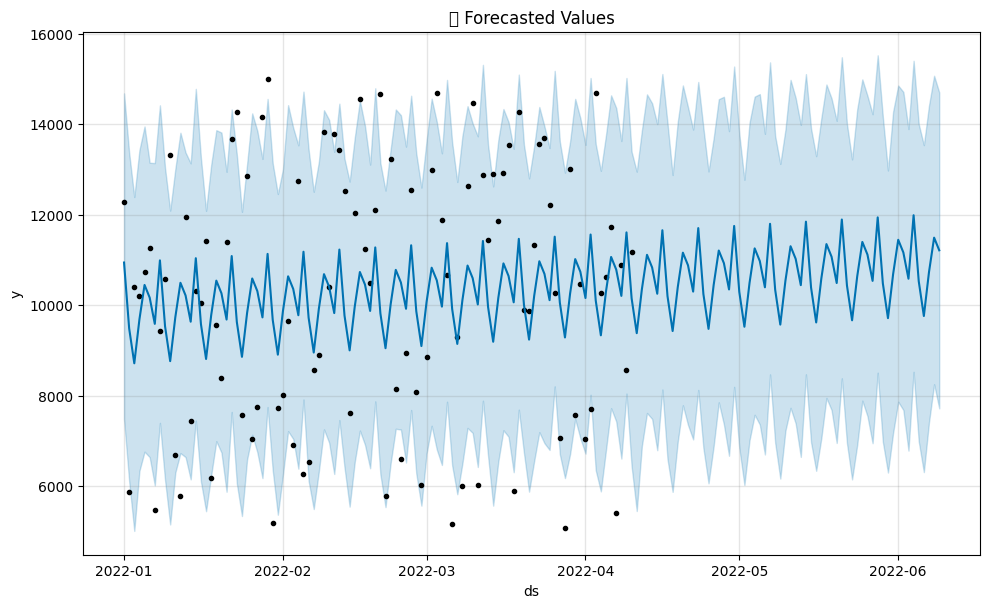

In [ ]:
import matplotlib.pyplot as plt
best_model.plot(forecast)
plt.title("Forecasted Values")
plt.show()


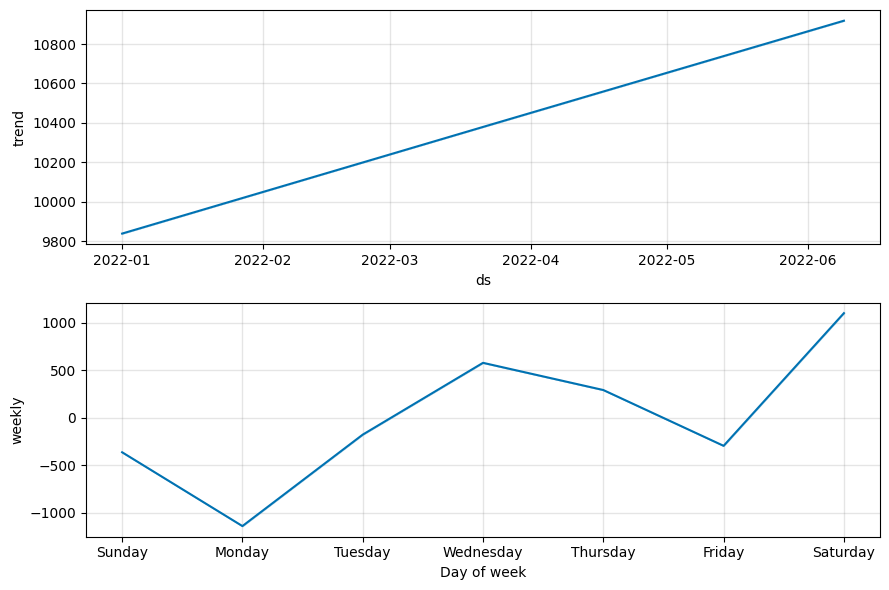

In [ ]:

best_model.plot_components(forecast)
plt.show()
